In [1]:
import wrds
import pandas_datareader.data as pdd
from fredapi import Fred
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
FETCH_START_DATE = "2007-01-01"
START_DATE = "2009-01-01"
END_DATE = "2024-12-31"

In [3]:
df_histconst = pd.read_csv(
    "S&P 500 Historical Components & Changes(11-16-2025).csv",
    index_col=0,
).rename(columns={"tickers": "ticker"})
df_histconst.index = pd.to_datetime(df_histconst.index)
df_histconst = df_histconst.loc[FETCH_START_DATE:]
df_histconst["ticker"] = df_histconst["ticker"].str.split(",")
df_histconst.head(10)

,ticker
date,
2007-01-03,"[A, AABA, AAPL, ABC, ABI, ABKFQ, ABT, ACS, ADB..."
2007-01-04,"[A, AABA, AAPL, ABC, ABI, ABKFQ, ABT, ACS, ADB..."
2007-01-05,"[A, AABA, AAPL, ABC, ABI, ABKFQ, ABT, ACS, ADB..."
2007-01-10,"[A, AABA, AAPL, ABC, ABI, ABKFQ, ABT, ACS, ADB..."
2007-01-11,"[A, AABA, AAPL, ABC, ABI, ABKFQ, ABT, ACS, ADB..."
2007-01-16,"[A, AABA, AAPL, ABC, ABI, ABKFQ, ABT, ACS, ADB..."
2007-01-22,"[A, AABA, AAPL, ABC, ABI, ABKFQ, ABT, ACS, ADB..."
2007-01-23,"[A, AABA, AAPL, ABC, ABI, ABKFQ, ABT, ACS, ADB..."
2007-01-24,"[A, AABA, AAPL, ABC, ABI, ABKFQ, ABT, ACS, ADB..."


In [4]:
hist_tickers = set()
for tickers_list in df_histconst["ticker"]:
    hist_tickers = hist_tickers.union(set(tickers_list))
print(
    f"Unique tickers found among the historical constituents of the S&P 500: {len(hist_tickers)}."
)

Unique tickers found among the historical constituents of the S&P 500: 912.


In [5]:
ticker_map = {
    # Bankruptcies / Delistings
    "LEHMQ": "LEH",  # Lehman Brothers
    "WAMUQ": "WM",  # Washington Mutual
    "EKDKQ": "EK",  # Eastman Kodak
    "MTLQQ": "GM",  # General Motors (Old)
    "SUNEQ": "SUNE",  # SunEdison
    "BTUUQ": "BTU",  # Peabody Energy
    "ANRZQ": "ANR",  # Alpha Natural Resources
    "RSHCQ": "RSH",  # RadioShack
    "CITGQ": "CIT",  # CIT Group
    "CCTYQ": "CC",  # Circuit City
    "ABKFQ": "ABK",  # Ambac Financial
    # GSEs (Delisted to OTC in 2008)
    "FNMA": "FNM",  # Fannie Mae (Old NYSE Ticker)
    "FMCC": "FRE",  # Freddie Mac (Old NYSE Ticker)
    # Formatting Differences (CRSP doesn't use dots)
    "BRK.B": "BRK",  # Berkshire Hathaway (CRSP relies on Permno/Share Class)
    "BF.B": "BF",  # Brown-Forman
    # Oddballs
    "PSKY": "PSB",  # PS Business Parks (Likely match)
    "SOLS": "SOL",  # Solstice? (Or potentially noise)
    "XYZ": None,  # Drop this, likely a placeholder error
}

In [6]:
for error, correct in ticker_map.items():
    hist_tickers.remove(error)
    hist_tickers.add(correct)
hist_tickers.remove(None)

In [7]:
try:
    db_num = wrds.Connection(wrds_username="audricms")
    print("Connection successful via .pgpass!")
except Exception as e:
    print(f"Connection failed: {e}")

Loading library list...
Done
Connection successful via .pgpass!


In [8]:
print("--- Table Schema: crsp.stocknames ---")
schema = db_num.describe_table(library="crsp", table="stocknames")
print(schema)

--- Table Schema: crsp.stocknames ---
Approximately 83280 rows in crsp.stocknames.
         name  nullable              type                              comment
0      permno      True           INTEGER                               PERMNO
1      namedt      True              DATE                                 None
2   nameenddt      True              DATE                                 None
3       shrcd      True          SMALLINT     Share Code as of Name Start Date
4      exchcd      True          SMALLINT                        Exchange Code
5       siccd      True           INTEGER       SIC Code as of Name Start Date
6      ncusip      True        VARCHAR(8)                                CUSIP
7      ticker      True        VARCHAR(8)                        Ticker Symbol
8      comnam      True       VARCHAR(35)                         Company Name
9      shrcls      True        VARCHAR(4)    Share Class as of Name Start Date
10     permco      True           INTEGER       

In [9]:
query_ids = f"""
SELECT DISTINCT
    ticker,
    permno,
    comnam AS company_name,
    shrcd,   -- (Share Code) to help identify Common Stock (10/11) vs others
    namedt,  -- Start Date for this ticker
    nameenddt -- End Date for this ticker
FROM 
    crsp.stocknames
WHERE 
    ticker IN {tuple(hist_tickers)}
"""

print("Fetching tickers' ids through time from CRSP...")
df_ids = db_num.raw_sql(query_ids)

Fetching tickers' ids through time from CRSP...


In [10]:
df_ids["namedt"] = pd.to_datetime(df_ids["namedt"])
df_ids["nameenddt"] = pd.to_datetime(df_ids["nameenddt"])

In [11]:
crsp_tickers = set(df_ids["ticker"])
for ticker in hist_tickers:
    if ticker not in crsp_tickers:
        print(ticker)

In [12]:
df = df_histconst.explode("ticker").reset_index()
df["clean_ticker"] = df["ticker"].map(ticker_map).fillna(df["ticker"])
df = pd.merge(
    left=df,
    right=df_ids,
    left_on="clean_ticker",
    right_on="ticker",
    how="inner",
)
valid_links = df[(df["date"] >= df["namedt"]) & (df["date"] <= df["nameenddt"])]
valid_links = valid_links.drop_duplicates(subset=["date", "permno"])
# Pivot: Index=Date, Columns=PERMNO, Values=1 (Present)
df_presence = (
    valid_links.assign(flag=1)
    .pivot(index="date", columns="permno", values="flag")
    .fillna(0)
    .astype(int)
    .astype(bool)
)

486.4335616438356
471 512


<Axes: xlabel='date'>

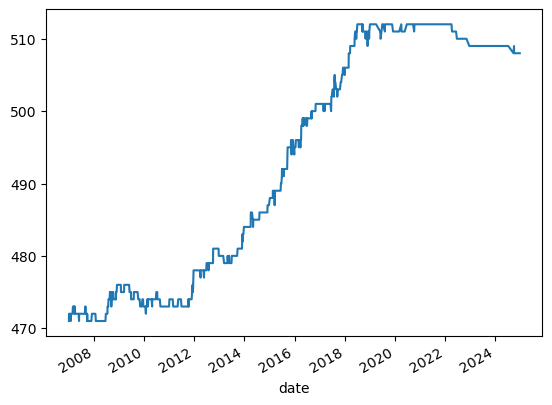

In [13]:
c = df_presence.sum(1)
print(c.mean())
print(c.min(), c.max())
c.plot()

In [14]:
print("--- Table Schema: crsp.wrds_dsfv2_query ---")
schema = db_num.describe_table(library="crsp", table="wrds_dsfv2_query")
print(schema)

--- Table Schema: crsp.wrds_dsfv2_query ---
Approximately 107691352 rows in crsp.wrds_dsfv2_query.
              name  nullable            type  \
0           permno      True         INTEGER   
1   secinfostartdt      True            DATE   
2     secinfoenddt      True            DATE   
3    securitybegdt      True            DATE   
4    securityenddt      True            DATE   
..             ...       ...             ...   
93          vwretd      True  NUMERIC(10, 6)   
94          vwretx      True  NUMERIC(10, 6)   
95          ewretd      True  NUMERIC(10, 6)   
96          ewretx      True  NUMERIC(10, 6)   
97          sprtrn      True  NUMERIC(10, 6)   

                                      comment  
0                                      PERMNO  
1             Security Information Start Date  
2               Security Information End Date  
3                    Begin Date of Stock Data  
4                      End Date of Stock Data  
..                                  

In [15]:
query_prices = f"""
SELECT 
    permno,
    yyyymmdd as date,
    dlyret,   -- Total Return
    dlyprc,   -- Price
    dlyclose, -- Close
    dlycap,   -- Market Cap (Size)
    shrout,   -- Shares Outstanding
    dlyvol,   -- Volume
    dlyhigh,  -- High (Volatility)
    dlylow,   -- Low (Volatility)
    dlyask,   -- Ask (Spread)
    dlybid,    -- Bid (Spread)
    icbindustry
FROM 
    crsp.wrds_dsfv2_query
WHERE
    permno in {tuple(df_presence.columns.astype(str))}
    AND yyyymmdd >= 20070101
"""
print("Fetching S&P 500 constituents price data from CRSP...")
df_prices = db_num.raw_sql(query_prices)

Fetching S&P 500 constituents price data from CRSP...


In [16]:
df_prices["date"] = pd.to_datetime(df_prices["date"], format="%Y%m%d")
df_prices = df_prices[df_prices["date"] >= FETCH_START_DATE]
df_prices = df_prices.sort_values(["date", "permno"]).drop_duplicates(
    subset=["date", "permno"], keep="first"
)

In [17]:
df_prices["icbindustry"] = df_prices["icbindustry"].replace("NOAVAIL", np.nan)
df_prices["icbindustry"] = df_prices.groupby("permno")["icbindustry"].ffill().bfill()

In [18]:
(df_prices.isna().sum() / len(df_prices)).round(3)

permno         0.000
date           0.000
dlyret         0.002
dlyprc         0.002
dlyclose       0.005
dlycap         0.002
shrout         0.000
dlyvol         0.002
dlyhigh        0.005
dlylow         0.005
dlyask         0.002
dlybid         0.002
icbindustry    0.000
dtype: float64

In [19]:
df_pfeatures = df_prices.copy()
# CLEANING (<4% Missing)

# Missing Returns -> 0 (Assumption: No trade/No change)
df_pfeatures["dlyret"] = df_pfeatures["dlyret"].fillna(0.0)
df_pfeatures["dlyclose"] = df_pfeatures.groupby("permno")["dlyclose"].ffill()
# Missing Volume -> 0
df_pfeatures["dlyvol"] = df_pfeatures["dlyvol"].fillna(0.0).clip(lower=0)
# Missing Market Cap -> Forward Fill (Caps don't vanish overnight)
# Then Backward Fill for IPO starts
df_pfeatures["dlycap"] = 1000 * df_pfeatures.groupby("permno")["dlycap"].ffill().bfill()
df_pfeatures["shrout"] = 1000 * df_pfeatures.groupby("permno")["shrout"].ffill()
# Missing High/Low -> Fill with Close (or Price)
df_pfeatures["dlyhigh"] = df_pfeatures["dlyhigh"].fillna(df_pfeatures["dlyclose"])
df_pfeatures["dlylow"] = df_pfeatures["dlylow"].fillna(df_pfeatures["dlyclose"])

# HYBRID LIQUIDITY FEATURE (29% Missing Bid/Ask)

# Calculate True Spread where possible
mid_price = (df_pfeatures["dlyask"] + df_pfeatures["dlybid"]) / 2
true_spread = (df_pfeatures["dlyask"] - df_pfeatures["dlybid"]) / (mid_price + 1e-9)
# Calculate Proxy Spread (High-Low Range)
# (High - Low) / Close
proxy_spread = (df_pfeatures["dlyhigh"] - df_pfeatures["dlylow"]) / (
    df_pfeatures["dlyclose"] + 1e-9
)
# Create 'Liquidity_Risk' Feature
df_pfeatures["liquidity_risk"] = true_spread.combine_first(proxy_spread).fillna(0.0)
# Final cleanup for any remaining NaNs
df_pfeatures["liquidity_risk"] = (
    df_pfeatures.groupby("permno")["liquidity_risk"]
    .transform(lambda x: x.fillna(x.rolling(20, min_periods=1).median()))
    .fillna(0.0)
)
df_pfeatures["log_liquidity_risk"] = np.log1p(df_pfeatures["liquidity_risk"])

# OTHER CORE FEATURES
# Log Return
df_pfeatures["log_ret"] = np.log1p(df_pfeatures["dlyret"])
clip_low = df_pfeatures["log_ret"].quantile(0.001)
clip_high = df_pfeatures["log_ret"].quantile(0.999)
df_pfeatures["log_ret"] = df_pfeatures["log_ret"].clip(clip_low, clip_high)

# Parkinson Volatility
high_low_ratio = df_pfeatures["dlyhigh"] / (df_pfeatures["dlylow"] + 1e-9)
high_low_ratio = high_low_ratio.clip(lower=1.0)
const = 1.0 / (4.0 * np.log(2.0))
df_pfeatures["parkinson_daily"] = const * (np.log(high_low_ratio) ** 2)
# Rolling Volatility (21 days)
df_pfeatures["volatility_parkinson"] = df_pfeatures.groupby("permno")[
    "parkinson_daily"
].transform(lambda x: np.sqrt(x.rolling(window=21, min_periods=10).mean()))
daily_vol_median = df_pfeatures.groupby("date")["volatility_parkinson"].transform(
    "median"
)
df_pfeatures["volatility_parkinson"] = df_pfeatures["volatility_parkinson"].fillna(
    daily_vol_median
)
df_pfeatures["volatility_parkinson"] = df_pfeatures["volatility_parkinson"].fillna(0.01)
df_pfeatures["log_volatility_parkinson"] = np.log(
    df_pfeatures["volatility_parkinson"] + 1e-6
)

# Momentum
df_pfeatures["mom_1m"] = (
    df_pfeatures.groupby("permno")["log_ret"]
    .transform(lambda x: x.rolling(window=21, min_periods=10).sum())
    .fillna(0.0)
)
df_pfeatures["mom_3m"] = (
    df_pfeatures.groupby("permno")["log_ret"]
    .transform(lambda x: x.rolling(window=63, min_periods=30).sum())
    .fillna(0.0)
)

# Relative Volume
df_pfeatures["vol_ma_20"] = df_pfeatures.groupby("permno")["dlyvol"].transform(
    lambda x: x.rolling(window=20, min_periods=5).mean()
)
df_pfeatures["relative_volume"] = df_pfeatures["dlyvol"] / (
    df_pfeatures["vol_ma_20"] + 1.0
)
df_pfeatures["log_relative_volume"] = np.log1p(df_pfeatures["relative_volume"]).fillna(
    np.log1p(1.0)
)

# Turnover (Volume / Shares)
df_pfeatures["turnover"] = df_pfeatures["dlyvol"] / (df_pfeatures["shrout"] + 1e-9)
df_pfeatures["log_turnover"] = np.log1p(df_pfeatures["turnover"])

# Log Market Cap
df_pfeatures["log_mkt_cap"] = np.log(df_pfeatures["dlycap"] + 1)
daily_stats = df_pfeatures.groupby("date")["log_mkt_cap"].agg(["mean", "std"])
df_pfeatures["cap_mean"] = df_pfeatures["date"].map(daily_stats["mean"])
df_pfeatures["cap_std"] = df_pfeatures["date"].map(daily_stats["std"])
df_pfeatures["mkt_cap_rank"] = (
    df_pfeatures["log_mkt_cap"] - df_pfeatures["cap_mean"]
) / df_pfeatures["cap_std"]
df_pfeatures = df_pfeatures.drop(columns=["log_mkt_cap", "cap_mean", "cap_std"])

# Drawdown
df_pfeatures["rolling_max_1y"] = df_pfeatures.groupby("permno")["dlyclose"].transform(
    lambda x: x.rolling(window=252, min_periods=21).max()
)
df_pfeatures["drawdown"] = (
    df_pfeatures["dlyclose"] / df_pfeatures["rolling_max_1y"]
) - 1.0
df_pfeatures["drawdown"] = df_pfeatures["drawdown"].fillna(0.0)
df_pfeatures["log_drawdown"] = np.log1p(df_pfeatures["drawdown"])


final_cols = [
    "date",
    "permno",
    "log_ret",  # Target/Signal
    "mkt_cap_rank",  # Size Context
    "mom_1m",
    "mom_3m",  # Trend Context
    "log_volatility_parkinson",  # Risk Context
    "log_drawdown",  # "Pain" Context
    "log_turnover",  # Liquidity Context
    "log_relative_volume",  # Attention Signal
    "log_liquidity_risk",  # Microstructure Signal
]

df_pfeatures = df_pfeatures[final_cols]
df_pfeatures.head(10)

,date,permno,log_ret,mkt_cap_rank,mom_1m,mom_3m,log_volatility_parkinson,log_drawdown,log_turnover,log_relative_volume,log_liquidity_risk
0,2007-01-03,10078,0.021898,0.708367,0.0,0.0,-4.60507,0.0,0.017925,0.693147,0.0
773,2007-01-03,10104,0.021357,1.950857,0.0,0.0,-4.60507,0.0,0.010036,0.693147,0.000571
5305,2007-01-03,10107,0.0,2.909303,0.0,0.0,-4.60507,0.0,0.007909,0.693147,0.0
9835,2007-01-03,10137,0.003696,-0.081465,0.0,0.0,-4.60507,0.0,0.007656,0.693147,0.003896
10882,2007-01-03,10138,0.044244,0.299808,0.0,0.0,-4.60507,0.0,0.009784,0.693147,0.000219
15413,2007-01-03,10145,-0.0031,1.211173,0.0,0.0,-4.60507,0.0,0.004284,0.693147,0.000886
19942,2007-01-03,10147,0.0,1.017277,0.0,0.0,-4.60507,0.0,0.019272,0.693147,0.000756
22381,2007-01-03,10225,0.005722,0.357222,0.0,0.0,-4.60507,0.0,0.006358,0.693147,0.000699
24226,2007-01-03,10299,-0.00033,0.061533,0.0,0.0,-4.60507,0.0,0.017011,0.693147,0.00066
26793,2007-01-03,10324,0.009213,0.545075,0.0,0.0,-4.60507,0.0,0.012581,0.693147,0.000161


In [20]:
(df_pfeatures.isna().sum() / len(df_pfeatures)).round(3)

date                        0.0
permno                      0.0
log_ret                     0.0
mkt_cap_rank                0.0
mom_1m                      0.0
mom_3m                      0.0
log_volatility_parkinson    0.0
log_drawdown                0.0
log_turnover                0.0
log_relative_volume         0.0
log_liquidity_risk          0.0
dtype: float64

In [21]:
df_pfeatures["permno"] = df_pfeatures["permno"].astype("int64")
index = df_pfeatures.set_index(["date", "permno"]).sort_index().index

In [22]:
query_ratios = f"""
SELECT 
    permno,
    public_date,
    ptb,                -- Price to Book
    pe_exi,             -- P/E (Exclude Extra Items)
    roe,                -- Return on Equity
    de_ratio,           -- Debt to Equity
    divyield            -- Dividend Yield
FROM wrdsapps.firm_ratio_ccm
WHERE permno IN {tuple(df_presence.columns.astype(str))}
    AND public_date >= '{FETCH_START_DATE}'
ORDER BY permno, public_date
"""

print("Fetching Financial Ratios from WRDS...")
df_ratios_raw = db_num.raw_sql(query_ratios)
df_ratios_raw["public_date"] = pd.to_datetime(df_ratios_raw["public_date"])

Fetching Financial Ratios from WRDS...


In [23]:
query_ratios_ibes = f"""
SELECT 
    permno,
    public_date,
    ptb,                -- Price to Book
    pe_exi,             -- P/E (Exclude Extra Items)
    roe,                -- Return on Equity
    de_ratio,           -- Debt to Equity
    divyield            -- Dividend Yield
FROM wrdsapps.firm_ratio_ibes
WHERE permno IN {tuple(df_presence.columns.astype(str))}
    AND public_date >= '{FETCH_START_DATE}'
ORDER BY permno, public_date
"""

print("Fetching Financial Ratios from WRDS...")
df_ratios_ibes_raw = db_num.raw_sql(query_ratios_ibes)
df_ratios_ibes_raw["public_date"] = pd.to_datetime(df_ratios_ibes_raw["public_date"])

Fetching Financial Ratios from WRDS...


In [24]:
df_ratios_raw.divyield = df_ratios_raw.divyield.fillna(0)
df_ratios_raw[["ptb", "pe_exi", "roe", "de_ratio"]] = df_ratios_raw.groupby("permno")[
    ["ptb", "pe_exi", "roe", "de_ratio"]
].ffill()
df_ratios_ibes_raw.divyield = df_ratios_ibes_raw.divyield.fillna(0)
df_ratios_ibes_raw[["ptb", "pe_exi", "roe", "de_ratio"]] = df_ratios_ibes_raw.groupby(
    "permno"
)[["ptb", "pe_exi", "roe", "de_ratio"]].ffill()
(100 * df_ratios_ibes_raw.isna().sum() / len(df_ratios_ibes_raw)).round(3)

permno         0.000
public_date    0.000
ptb            0.531
pe_exi         0.649
roe            0.611
de_ratio       0.033
divyield       0.000
dtype: float64

In [25]:
(100 * df_ratios_raw.isna().sum() / len(df_ratios_raw)).round(3)

permno         0.000
public_date    0.000
ptb            0.516
pe_exi         0.888
roe            0.589
de_ratio       0.014
divyield       0.000
dtype: float64

In [49]:
df_daily = pd.DataFrame(index=index).reset_index()

keys = ["permno", "public_date"]
common_cols = [
    c
    for c in df_ratios_raw.columns
    if c in df_ratios_ibes_raw.columns and c not in keys
]

df_main = df_ratios_raw.sort_values("public_date").copy()
df_main["public_date"] = pd.to_datetime(df_main["public_date"])
df_main["permno"] = df_main["permno"].astype("int64")
df_ibes = df_ratios_ibes_raw.sort_values("public_date").copy()
df_ibes["public_date"] = pd.to_datetime(df_ibes["public_date"])
df_ibes["permno"] = df_ibes["permno"].astype("int64")

lookback_limit = pd.Timedelta(days=180)
df_ratios = pd.merge_asof(
    df_daily,
    df_main,
    left_on="date",
    right_on="public_date",
    by="permno",
    direction="backward",
    tolerance=lookback_limit,
)

df_ibes = df_ibes.rename(columns={c: f"{c}_ibes" for c in common_cols})
df_ratios = pd.merge_asof(
    df_ratios,
    df_ibes,
    left_on="date",
    right_on="public_date",
    by="permno",
    direction="backward",
    tolerance=lookback_limit,
    suffixes=(None, "_drop"),
)

for col in common_cols:
    before = df_ratios[col].isna().sum()
    df_ratios[col] = df_ratios[col].fillna(df_ratios[col])
    after = df_ratios[col].isna().sum()

cols_to_drop = [
    c for c in df_ratios.columns if "_ibes" in c or "public_date" in c or "_drop" in c
]
df_ratios.drop(columns=cols_to_drop, inplace=True)

In [27]:
df_ratios

,date,permno,ptb,pe_exi,roe,de_ratio,divyield
0,2007-01-03,10078,<NA>,<NA>,<NA>,<NA>,<NA>
1,2007-01-03,10104,<NA>,<NA>,<NA>,<NA>,<NA>
2,2007-01-03,10107,<NA>,<NA>,<NA>,<NA>,<NA>
3,2007-01-03,10137,<NA>,<NA>,<NA>,<NA>,<NA>
4,2007-01-03,10138,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...
3127879,2024-12-31,93096,1.966211,12.490939,0.166753,3.411637,0.031126
3127880,2024-12-31,93132,59.380637,47.717172,8.445487,52.452973,0.0
3127881,2024-12-31,93246,3.732255,32.16805,0.120684,1.161013,0.0
3127882,2024-12-31,93429,4.643522,26.621253,0.187383,1.069493,0.012897


In [28]:
ibes_permno = set(df_ratios_ibes_raw.permno.unique())
main_permno = set(df_ratios_raw.permno.unique())
leftover_permno = df_presence.columns.difference(main_permno).difference(ibes_permno)

In [50]:
df_icb = df_prices[["date", "permno", "icbindustry"]]
df_merged = pd.merge(df_ratios, df_icb, on=["date", "permno"], how="left")
keys = ["date", "permno", "icbindustry"]
ratio_cols = [
    c
    for c in df_merged.columns
    if c not in keys and pd.api.types.is_numeric_dtype(df_merged[c])
]
ind_medians = df_merged.groupby(["date", "icbindustry"])[ratio_cols].transform("median")
df_merged[ratio_cols] = df_merged[ratio_cols].fillna(ind_medians)

df_ratios = df_merged.drop(columns=["icbindustry"])

In [51]:
df_ratios["log_dte"] = np.log1p(df_ratios["de_ratio"].clip(lower=0, upper=100))
df_ratios["log_dte"] = df_ratios["log_dte"].clip(lower=-10, upper=10.0)
df_ratios["log_ptb"] = np.log1p(df_ratios["ptb"])
df_ratios["earnings_yield"] = 1.0 / (df_ratios["pe_exi"] + 1e-6)
df_ratios["earnings_yield"] = df_ratios["earnings_yield"].clip(-0.5, 0.5)
df_ratios = df_ratios.drop(columns=["de_ratio", "pe_exi", "ptb"])
df_ratios["roe"] = df_ratios["roe"].clip(lower=-2, upper=2)
df_ratios

,date,permno,roe,divyield,log_dte,log_ptb,earnings_yield
0,2007-01-03,10078,<NA>,<NA>,<NA>,<NA>,<NA>
1,2007-01-03,10104,<NA>,<NA>,<NA>,<NA>,<NA>
2,2007-01-03,10107,<NA>,<NA>,<NA>,<NA>,<NA>
3,2007-01-03,10137,<NA>,<NA>,<NA>,<NA>,<NA>
4,2007-01-03,10138,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...
3127879,2024-12-31,93096,0.166753,0.031126,1.484246,1.087285,0.080058
3127880,2024-12-31,93132,2.0,0.0,3.978802,4.100668,0.020957
3127881,2024-12-31,93246,0.120684,0.0,0.770577,1.554402,0.031087
3127882,2024-12-31,93429,0.187383,0.012897,0.727304,1.730508,0.037564


In [31]:
fred = Fred(api_key="5485a09a090ec54c5c3d5b3876246f8f")

In [32]:
monthly_macro_data = {}

# UNEMPLOYMENT (UNRATE)
raw_unrate = fred.get_series_first_release("UNRATE")
raw_unrate.index = pd.to_datetime(raw_unrate.index)
raw_unrate = pd.to_numeric(raw_unrate, errors="coerce")
raw_unrate = raw_unrate[
    raw_unrate.index >= pd.to_datetime(FETCH_START_DATE) - pd.DateOffset(months=13)
]
monthly_macro_data["unemp_rate"] = raw_unrate.div(100).clip(0.0, 0.3)
# Delta: Change from previous month
monthly_macro_data["unemp_delta"] = raw_unrate.diff()

# CPI (CPIAUCSL)
raw_cpi = fred.get_series_first_release("CPIAUCSL")
raw_cpi.index = pd.to_datetime(raw_cpi.index)
raw_cpi = pd.to_numeric(raw_cpi, errors="coerce")
raw_cpi = raw_cpi[
    raw_cpi.index >= pd.to_datetime(FETCH_START_DATE) - pd.DateOffset(months=13)
]
monthly_macro_data["cpi_yoy"] = raw_cpi.pct_change(12).clip(lower=-0.2, upper=0.3)

# PPI (PPIACO)
raw_ppi = fred.get_series_first_release("PPIACO")
raw_ppi.index = pd.to_datetime(raw_ppi.index)
raw_ppi = pd.to_numeric(raw_ppi, errors="coerce")
raw_ppi = raw_ppi[
    raw_ppi.index >= pd.to_datetime(FETCH_START_DATE) - pd.DateOffset(months=13)
]
monthly_macro_data["ppi_yoy"] = raw_ppi.pct_change(12).clip(lower=-0.2, upper=0.3)

/opt/miniconda3/envs/aml/lib/python3.11/site-packages/pandas/core/indexes/base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/opt/miniconda3/envs/aml/lib/python3.11/site-packages/pandas/core/indexes/base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)
/var/folders/l4/rqys14ws2955nprxbdsj722r0000gn/T/ipykernel_15979/2643877507.py:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method

In [33]:
df_monthly_macro = pd.DataFrame(monthly_macro_data)
df_monthly_macro.index.name = "date"
# LAG CORRECTION: Shift dates +1 Month + 15 Days
df_monthly_macro.index = df_monthly_macro.index + pd.DateOffset(months=1, days=15)

In [34]:
daily_macro_tickers = {
    "T10Y2Y": "yield_curve",  # Slope
    "DGS10": "risk_free",  # Level
    "VIXCLS": "vix",  # Volatility
}

daily_macro_data = {}
for ticker, name in daily_macro_tickers.items():
    s = fred.get_series(ticker, observation_start=FETCH_START_DATE)
    daily_macro_data[name] = s

df_daily_macro = pd.DataFrame(daily_macro_data)
df_daily_macro.index = pd.to_datetime(df_daily_macro.index.rename("date"))
# Lag Daily_macro by 1 day (Trade using yesterday's close)
df_daily_macro = df_daily_macro.shift(1)

In [45]:
df_monthly_macro = df_monthly_macro.resample("B").ffill()
df_macro = pd.merge(left=df_monthly_macro, right=df_daily_macro, on="date", how="left")
df_macro = df_macro.ffill()
df_macro["log_vix"] = np.log1p(df_macro["vix"])
df_macro = df_macro.drop(columns="vix")

In [52]:
df_pfr = pd.merge(left=df_pfeatures, right=df_ratios, on=["date", "permno"], how="left")
df_num = pd.merge(left=df_pfr, right=df_macro, on="date", how="left")

In [53]:
df_num[df_num.date >= START_DATE].isna().sum()

date                        0
permno                      0
log_ret                     0
mkt_cap_rank                0
mom_1m                      0
mom_3m                      0
log_volatility_parkinson    0
log_drawdown                0
log_turnover                0
log_relative_volume         0
log_liquidity_risk          0
roe                         0
divyield                    0
log_dte                     0
log_ptb                     0
earnings_yield              0
unemp_rate                  0
unemp_delta                 0
cpi_yoy                     0
ppi_yoy                     0
yield_curve                 0
risk_free                   0
log_vix                     0
dtype: int64

In [54]:
df_num = (
    df_num.set_index(["date", "permno"])
    .sort_index()
    .loc[START_DATE:END_DATE]
    .astype("float32")
)
df_num.head(10)

log_ret  mkt_cap_rank    mom_1m    mom_3m  \
date       permno                                               
2009-01-02 10078   0.099585     -0.316011  0.261179 -0.490736   
           10104   0.037636      2.209464  0.153518 -0.057008   
           10107   0.044765      2.705739  0.059796 -0.261766   
           10137   0.011160      0.139247  0.040690  0.038843   
           10138   0.026728      0.496859  0.210156 -0.308680   
           10145   0.054244      1.235578  0.265051 -0.084519   
           10147   0.036572      1.140579  0.043282 -0.079616   
           10225   0.036394      0.216199  0.151275 -0.216784   
           10299   0.030717      0.038701  0.190155 -0.207604   
           10324   0.025291      1.002898  0.125525 -0.137454   

                   log_volatility_parkinson  log_drawdown  log_turnover  \
date       permno                                                         
2009-01-02 10078                  -3.124312     -1.433730      0.008196   
           10104                  -3.580416     -0.244957      0.005545   
           10107                  -3.635783     -0.532045      0.005658   
           10137                  -3.682822     -0.625489      0.012092   
           10138                  -3.041432     -0.579972      0.009093   
           10145                  -3.458507     -0.588460      0.007027   
           10147                  -3.432155     -0.503617      0.007250   
           10225                  -3.624751     -0.546212      0.004792   
           10299                  -3.359788     -0.490990      0.017361   
           10324                  -3.634443     -0.201312      0.008527   

                   log_relative_volume  log_liquidity_risk       roe  ...  \
date       permno                                                     ...   
2009-01-02 10078              0.610908            0.002375 -0.233247  ...   
           10104              0.560827            0.000000  0.270818  ...   
           10107              0.556535            0.000984  0.506104  ...   
           10137              0.627886            0.000293  0.124465  ...   
           10138              0.589042            0.000275  0.246094  ...   
           10145              0.522302            0.000578  0.272134  ...   
           10147              0.538347            0.000923  0.120243  ...   
           10225              0.477162            0.005585  0.094917  ...   
           10299              0.574403            0.000438  0.173752  ...   
           10324              0.657243            0.000147  0.061493  ...   

                    log_dte   log_ptb  earnings_yield  unemp_rate  \
date       permno                                                   
2009-01-02 10078   0.962076  0.563315       -0.486911       0.067   
           10104   0.651517  1.520489        0.062606       0.067   
           10107   0.665510  1.815450        0.098251       0.067   
           10137   1.324993  0.846634        0.085056       0.067   
           10138   0.142635  1.487650        0.067438       0.067   
           10145   1.305386  1.166152        0.112702       0.067   
           10147   0.564917  0.956516        0.068768       0.067   
           10225   0.844153  0.661824        0.098595       0.067   
           10299   0.000000  1.529725        0.079566       0.067   
           10324   0.256643  1.247891        0.022299       0.067   

                   unemp_delta   cpi_yoy   ppi_yoy  yield_curve  risk_free  \
date       permno                                                            
2009-01-02 10078           0.2  0.011849 -0.010591         1.49       2.25   
           10104           0.2  0.011849 -0.010591         1.49       2.25   
           10107           0.2  0.011849 -0.010591         1.49       2.25   
           10137           0.2  0.011849 -0.010591         1.49       2.25   
           10138           0.2  0.011849 -0.010591         1.49       2.25   
           10145           0.2  0.0118

In [55]:
df_num.describe().to_csv("desc.csv")

In [56]:
dates = df_num.index.get_level_values(0).unique()
permnos = df_num.index.get_level_values(1).unique()
df_presence = df_presence.reindex(index=dates, columns=permnos).ffill()

In [41]:
n = len(df_num)
part1_idx = n // 3
part2_idx = 2 * (n // 3)

# Save the chunks
df_num.iloc[:part1_idx].to_parquet(
    "sp500_numerical_data_part1.parquet", compression="snappy"
)
df_num.iloc[part1_idx:part2_idx].to_parquet(
    "sp500_numerical_data_part2.parquet", compression="snappy"
)
df_num.iloc[part2_idx:].to_parquet(
    "sp500_numerical_data_part3.parquet", compression="snappy"
)